# Reações Químicas usando VASP e ASE

Autor: [Prof. Elvis do A. Soares](https://github.com/elvissoares) 

Contato: [elvis@peq.coppe.ufrj.br](mailto:elvis@peq.coppe.ufrj.br) - [Programa de Engenharia Química, PEQ/COPPE, UFRJ, Brasil](https://www.peq.coppe.ufrj.br/)

---

Importando variáveis do VASP

In [1]:
import os
# Definindo o path para os arquivos de potencial de pseudopotenciais do VASP
# Certifique-se de que o caminho esteja correto para o seu sistema
os.environ['VASP_PP_PATH'] = '/home/elvis/Programs/vasp-6.5.1/pp'
os.environ['ASE_VASP_COMMAND'] = 'mpirun -np 1 vasp_std_gpu'
os.environ['NO_STOP_MESSAGE'] = '1' # to avoid warning from mpirun

# Importando o VASP calculator do ASE
from ase.calculators.vasp import Vasp

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms, Atom
from ase.build import molecule
from ase.constraints import FixAtoms
from ase.io import read, write
from ase.visualize import view

# Reação Química em Bulk


## Reação de Oxidação de CO

$CO + (1/2)O_2 \to CO_2$

Estado Inicial do sistema

In [3]:
CO_mol = Atoms([Atom('O', [0,0,-1.14362357]),
                  Atom('C', [0,0,0.0])])    
CO_mol.translate([4,4,3.0])                      

O2_mol = Atoms([Atom('O', [0, 0, -0.61674143], magmom=1),
                  Atom('O', [0, 0, 0.61674143], magmom=1)])
O2_mol.translate([4,4,6])  

CO_mol2 = Atoms([Atom('C', [0,0,0.0]),
                  Atom('O', [0,0,1.14362357])]) 
CO_mol2.translate([4,4,9.0])   

initial_state = CO_mol + O2_mol + CO_mol2
initial_state.set_cell([8.0,8.0,12.0])  
initial_state.pbc = True  

constraint = FixAtoms(mask=[atom.symbol=='C' for atom in initial_state])
initial_state.set_constraint(constraint)

In [4]:
view(initial_state, viewer='x3d')

In [5]:
calc = Vasp(directory='reacao/initial_state',
            xc='PBE',                                   # funcional
            encut=450,                                  # safe default for PAW-PBE sets
            kpts=[1, 1, 1],gamma=True,                  # k-points
            ismear=0, sigma=0.05,                       # Gaussian smearing for molecules
            ediff=1e-6, ediffg=-0.02,                   # SCF and force criteria (~0.02 eV/Å)
            ibrion=2, nsw=100,                           # adjusting ionic positions 
            lreal='Auto',
            lwave=True, lcharg=True,lvtot=True,  # keep WAVECAR/CHGCAR/LOCPOT for post-processing
            atoms=initial_state)

calc.calculate(initial_state)

/home/elvis/Programs/miniforge3/envs/quantum/lib/python3.13/site-packages/ase/calculators/vasp/vasp.py:1004: UserWarning: Magnetic moment data not written in OUTCAR (LORBIT<10), setting magnetic_moments to zero.
Set LORBIT>=10 to get information on magnetic moments
  warn('Magnetic moment data not written in OUTCAR (LORBIT<10),'


In [6]:
E_initial = initial_state.get_potential_energy()       

print('Energia dos reagentes = {:.3f} eV'.format(E_initial))

Energia dos reagentes = -38.767 eV


Estado final

In [7]:
CO2_mol = Atoms([Atom('O', [0, 0, -1.17676]),
                Atom('C', [0, 0, 0.0]),
                Atom('O', [0, 0, 1.17676])])
CO2_mol.translate([4.0,4.0,3.0])

CO2_mol2 = Atoms([Atom('O', [0, 0, -1.17676]),
                Atom('C', [0, 0, 0.0]),
                Atom('O', [0, 0, 1.17676])])
CO2_mol2.translate([4.0,4.0,9.0])

final_state = CO2_mol + CO2_mol2
final_state.set_cell([8.0,8.0,12.0])
final_state.pbc = True  

constraint = FixAtoms(mask=[atom.symbol=='C' for atom in final_state])
final_state.set_constraint(constraint)

In [8]:
view(final_state, viewer='x3d')

In [9]:
calc = Vasp(directory='reacao/final_state',
            xc='PBE',                                   # funcional
            encut=450,                                  # safe default for PAW-PBE sets
            kpts=[1, 1, 1],gamma=True,                  # k-points
            ismear=0, sigma=0.05,                       # Gaussian smearing for molecules
            ediff=1e-6, ediffg=-0.02,                   # SCF and force criteria (~0.02 eV/Å)
            ibrion=2, nsw=100,                           # no ionic steps, just a single-point calculation   
            lreal='Auto',
            lwave=True, lcharg=True,lvtot=True,         # keep WAVECAR/CHGCAR/LOCPOT for post-processing
            atoms=final_state)

calc.calculate(final_state)

In [10]:
E_final = final_state.get_potential_energy()       

print('Energia dos produtos = {:.3f} eV'.format(E_final))

Energia dos produtos = -45.910 eV


Energia da reação

In [11]:
E_react = E_final-E_initial

print("CO + (1/2)O2 -> CO2 \nE_reac = {0:1.3f} eV".format(0.5*E_react))

CO + (1/2)O2 -> CO2 
E_reac = -3.572 eV


## Métodos de Estados Transientes

Estamos interessados em determinar a posição dos íons em estados intermediários $\boldsymbol{R}_a^{(\alpha)}$ dado que conhecemos as posições $\boldsymbol{R}_a^{(i)}$ do estado inicial e as posições $\boldsymbol{R}_a^{(f)}$ do estado final do sistema.


### 1. Método da banda elástica (Elastic Band)

Vamos definir uma função objetiva Langrangeana para os estados intermediários dada por 

$$\mathcal{L} = \sum_{\alpha=1}^{n_\alpha} \left[ E(\boldsymbol{R}_a^{(\alpha)}) + \frac{k}{2}(\boldsymbol{R}_a^{(\alpha)}-\boldsymbol{R}_a^{(\alpha-1)})^2 \right]+ \frac{k}{2}(\boldsymbol{R}_a^{(f)}-\boldsymbol{R}_a^{(n_\alpha)})^2$$

com $\alpha=0$ sendo o estado inicial do sistema. As energias dos estados intermediários $E(\boldsymbol{R}_a^{(\alpha)})$ são calculados pelo DFT assim como as forças sobre os íons dadas por $\boldsymbol{F}_b = - \nabla_b E(\boldsymbol{R}_a)$. Os termos harmônicos aparecem como penalização afim de aumentar a distância entre as posições dos estados intermediários. 

### 2. Método de nudged elastic band (NEB)

Podemos definir um deslocamento unitário entre imagens como sendo 
$$\boldsymbol{\tau}_a^{(\alpha)} = \frac{\boldsymbol{R}_a^{(\alpha+1)}-\boldsymbol{R}_a^{(\alpha-1)}}{|\boldsymbol{R}_a^{(\alpha+1)}-\boldsymbol{R}_a^{(\alpha-1)}|}$$
tal que as forças possam ser projetadas ao longo dessa direção.

- componente paralela: $\boldsymbol{F}_{a||} = (\boldsymbol{F}_a \cdot \boldsymbol{\tau}_a)\boldsymbol{\tau}_a$
- componente perpendicular: $\boldsymbol{F}_{a\perp} = \boldsymbol{F}_{a} -\boldsymbol{F}_{a||} $ 


### 3. NEB com climbing image

In [ ]:
from ase.mep import NEB
from ase.optimize import FIRE

# Recuperando os estados inicial e final
calc = Vasp(restart=True,directory='reacao/initial_state')
initial = calc.get_atoms()

calc = Vasp(restart=True,directory='reacao/final_state')
final = calc.get_atoms()


# Definindo vínculos para os átomos de C
constraint = FixAtoms(mask=[atom.symbol=='C' for atom in initial])
initial.set_constraint(constraint)
final.set_constraint(constraint)

# 1) Make band with N images between A and B
nimages = 3                        # internal images (exclude endpoints)
images = [initial]

# 2) Attach one VASP calculator per internal image (single-point forces only)
for i in range(nimages):
    image = initial.copy()
    image.set_constraint(constraint)
    image.calc = Vasp(
        directory=f'reacao/co_bulk_neb/{i:02d}',
        xc='PBE', encut=450,
        kpts=[1,1,1], gamma=True,    # adjust if periodic/metallic
        ismear=0, sigma=0.05,        # molecules; for metals use ismear=1, sigma~0.2
        ibrion=-1, nsw=0,            # NEB optimizer moves atoms; VASP only gives E,F
    )
    images.append(image)

images.append(final)

# 3) CI-NEB with IDPP-preconditioned path
neb = NEB(images, k=0.1, climb=True)
neb.interpolate(apply_constraint=True)     # better initial path than linear

# 4) Optimize the band (FIRE/BFGS are fine; maximum step of 0.8 Å)
opt = FIRE(neb,a = 0.25, dt = 0.1, maxstep=0.25, trajectory='neb_bulk.traj', logfile='neb_bulk.log')
opt.run(fmax=0.05)

np.True_

Text(0, 0.5, 'Energia [eV]')

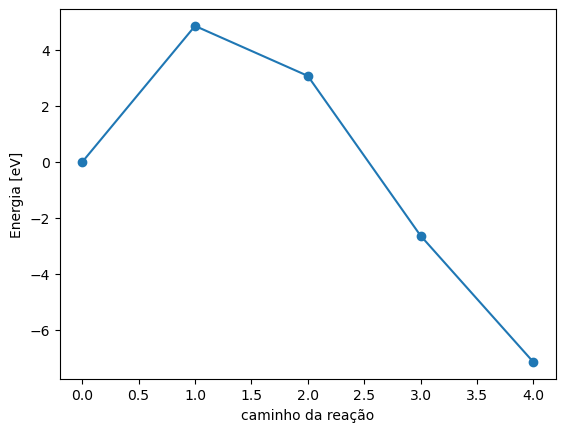

In [59]:
energies = np.array([image.get_total_energy() for image in images])

plt.plot(range(len(energies)),energies- energies[0],'o-')
plt.xlabel("caminho da reação")
plt.ylabel("Energia [eV]")

In [36]:
# Transition state takes maximum energy in the reaction path
ts_index = np.argmax(energies)

E_act_forward = energies[ts_index] - energies[0]
E_act_backward = energies[ts_index] - energies[-1]

print(f"ts_index       = {ts_index}")
print(f"E_act_forward  = {E_act_forward:.3f} eV")
print(f"E_act_backward = {E_act_backward:.3f} eV")

ts_index       = 1
E_act_forward  = 4.855 eV
E_act_backward = 11.999 eV


Lendo arquivo de trajetória e exportando um GIF da reação

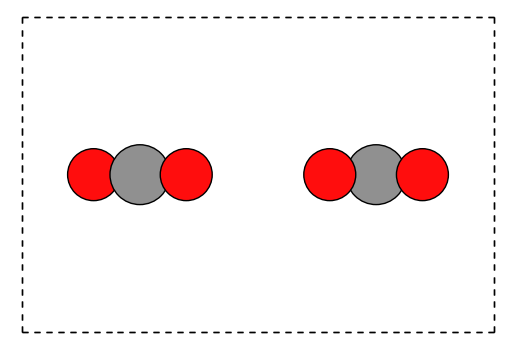

In [54]:
from ase.io import Trajectory

traj = Trajectory("neb_bulk.traj")
write("CO_oxidation_bulk_NEB.gif", traj, rotation="0x,90y,0z")

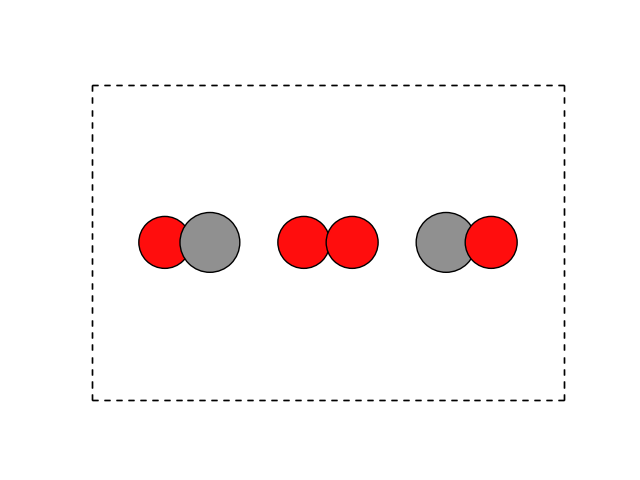

In [55]:
from IPython.display import Image
Image("CO_oxidation_bulk_NEB.gif", format="gif", width=500)

Usando pacote NEBTools

In [ ]:
from ase.mep import NEBTools

#Barrier analysis and plot
tools = NEBTools(images)
Ef, dE = tools.get_barrier()        # Ef = forward barrier (eV), dE = reaction energy (eV)
print(f'Forward barrier: {Ef:.3f} eV | Reaction energy: {dE:.3f} eV')

Forward barrier: 4.855 eV | Reaction energy: -7.143 eV


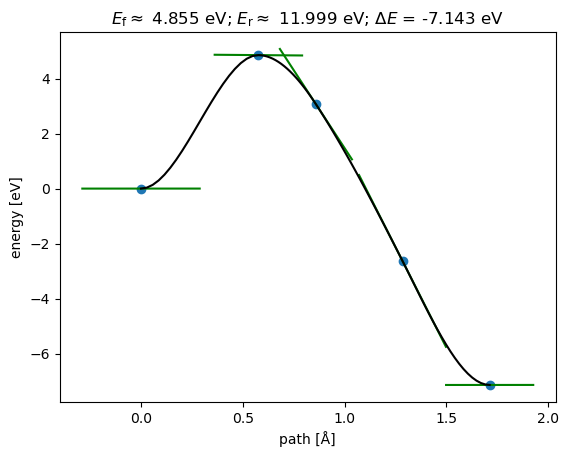

In [ ]:
fig = tools.plot_band()     # energy vs. reaction coordinate
fig.savefig('CO_oxidation_bulk_NEB_barrier.png')

## Lei de Arrhenius 

A taxa de reação pode ser calculada por 

$k = A \exp \left( - \frac{E_f}{k_B T}\right)$

In [71]:
# Para T = 300 K (temperatura ambiente)
kBT = 1/40 # em eV

np.exp(-0.5*Ef/kBT)

np.float64(6.7131426781913264e-43)

In [72]:
# Para T = 2000 K (temperatura de combustão da gasolina)
kBT = 1/40 * (2000/300) # em eV

np.exp(-0.5*Ef/kBT)

np.float64(4.721053061478135e-07)